In [80]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Loading to the Dataset

In [81]:
# 데이터가 있는 폴더
data_dir="C:/Users/user/Desktop/clothes_dataset"

In [82]:
# Confirm the amount of data
from glob import glob
folderList=glob(data_dir + '/*')
total=0
for folder  in folderList:
    print(folder)
    fileList=glob(folder + '/*.jpg' )
    print(len(fileList))
    total+=len(fileList)
print("총 데이터 수 =", total)

C:/Users/user/Desktop/clothes_dataset\black_dress
450
C:/Users/user/Desktop/clothes_dataset\black_pants
871
C:/Users/user/Desktop/clothes_dataset\black_shirt
715
C:/Users/user/Desktop/clothes_dataset\black_shoes
772
C:/Users/user/Desktop/clothes_dataset\black_shorts
429
C:/Users/user/Desktop/clothes_dataset\blue_dress
502
C:/Users/user/Desktop/clothes_dataset\blue_pants
798
C:/Users/user/Desktop/clothes_dataset\blue_shirt
741
C:/Users/user/Desktop/clothes_dataset\blue_shoes
773
C:/Users/user/Desktop/clothes_dataset\blue_shorts
557
C:/Users/user/Desktop/clothes_dataset\brown_pants
311
C:/Users/user/Desktop/clothes_dataset\brown_shoes
464
C:/Users/user/Desktop/clothes_dataset\brown_shorts
40
C:/Users/user/Desktop/clothes_dataset\green_pants
227
C:/Users/user/Desktop/clothes_dataset\green_shirt
230
C:/Users/user/Desktop/clothes_dataset\green_shoes
455
C:/Users/user/Desktop/clothes_dataset\green_shorts
135
C:/Users/user/Desktop/clothes_dataset\red_dress
800
C:/Users/user/Desktop/clothes_da

In [83]:
batch_size = 32
img_height = 180
img_width = 180

In [84]:
# split training data and test data in data_dir
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="training",   
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
    subset="validation",    #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12000 files belonging to 24 classes.
Using 9600 files for training.
Found 12000 files belonging to 24 classes.
Using 2400 files for validation.


In [85]:
# 폴더명을 가져옴
class_names = train_ds.class_names
print(class_names)

['black_dress', 'black_pants', 'black_shirt', 'black_shoes', 'black_shorts', 'blue_dress', 'blue_pants', 'blue_shirt', 'blue_shoes', 'blue_shorts', 'brown_pants', 'brown_shoes', 'brown_shorts', 'green_pants', 'green_shirt', 'green_shoes', 'green_shorts', 'red_dress', 'red_pants', 'red_shoes', 'white_dress', 'white_pants', 'white_shoes', 'white_shorts']


## Modeling

In [86]:
# 성능을 높이도록 데이터세트 구성하기
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ]
)

In [110]:
### 모델 제작

num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    #모델안에 스케일링 넣어주면 새로운 데이터 넣어서 추론할때 스케일링을 하지 않아도 됨
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),      
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [111]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 256)       147712    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 256)      0         
 g2D)                                                

In [112]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])



from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
modelpath="c:/data/model/clothes/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath,
                                save_best_only=True,
                                verbose=1) #verbose기본값이 0임, 1을 지정하지 않으면 결과가 화면에 출력되지 않음

early_stopping_cb = EarlyStopping(patience=10,
                                monitor='val_loss',
                                restore_best_weights=True # 멈출때의 가장 베스트 weight를 가져오기
                                )

def scheduler(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
lr_scheduler_cb = LearningRateScheduler(scheduler) # 러닝레이트 설정


epochs=100
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[checkpointer, lr_scheduler_cb, early_stopping_cb]
)

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 1.5404 - accuracy: 0.5278
Epoch 1: val_loss improved from inf to 0.97585, saving model to c:/data/model/clothes\01-0.6975.hdf5
300/300 [==============================] - 27s 83ms/step - loss: 1.5404 - accuracy: 0.5278 - val_loss: 0.9758 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.7026
Epoch 2: val_loss improved from 0.97585 to 0.74097, saving model to c:/data/model/clothes\02-0.7763.hdf5
300/300 [==============================] - 24s 79ms/step - loss: 0.9292 - accuracy: 0.7026 - val_loss: 0.7410 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.7552
Epoch 3: val_loss improved from 0.74097 to 0.71594, saving model to c:/data/model/clothes\03-0.7850.hdf5
300/300 [==============================] - 24s 79ms/step - loss: 0.7647 - accuracy: 0.7552 - val_loss: 0.7

In [113]:
import pandas as pd
hist_df=pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,1.540438,0.527812,0.975848,0.697500,0.001
1,0.929222,0.702604,0.740968,0.776250,0.001
2,0.764747,0.755208,0.715945,0.785000,0.001
3,0.677979,0.783229,0.632212,0.804167,0.001
4,0.621624,0.797292,0.628508,0.807500,0.001


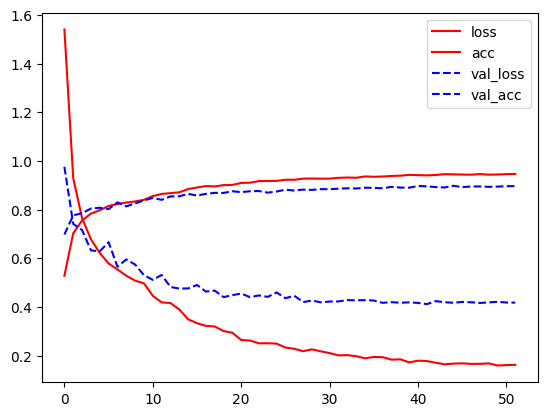

In [114]:
# y_vloss에 테스트셋(여기서는 검증셋)의 오차를 저장합니다.
y_vloss=hist_df['val_loss']

# y_loss에 학습셋의 오차를 저장합니다.
y_loss=hist_df['loss']

# x 값을 지정하고 테스트셋(검증셋)의 오차를 빨간색으로, 학습셋의 오차를 파란색으로 표시합니다.
plt.plot(hist_df['loss'],'r',label='loss')
plt.plot(hist_df['accuracy'],'r',label='acc')
plt.plot(hist_df['val_loss'],'--b',label='val_loss')
plt.plot(hist_df['val_accuracy'],'--b',label='val_acc')
plt.legend()

## Validation

In [115]:
X_test,y_test=[],[]
for x, y in val_ds:
    if len(y)==32:
        X_test.append(x.numpy())
        y_test.append(y.numpy())


X_test=np.reshape(X_test, (-1,180,180,3))
y_test=np.reshape(y_test,(-1))

In [116]:
y_test

array([ 8, 17,  7, ...,  6,  3,  2])

In [117]:
test_yhat=model.predict(X_test)
# 소프트맥스일때 y값이 원핫인코딩 되어 있다면 아래의 과정1,2가 필요함()
predict_y=np.argmax(test_yhat, axis=1) # [과정1]
real_y=y_test.copy()  # 원핫인코딩 되어 있지 않음으로

In [118]:
# 오차행렬표임 (교재 388쪽의 하단내용)
import pandas as pd
from sklearn.metrics import confusion_matrix
conMatrix=confusion_matrix(real_y, predict_y)
conMatrix

array([[ 79,   0,   5,   1,   0,   0,   0,   0,   0,   0,   1,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3, 136,   5,   6,   3,   0,   1,   0,   1,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  6,   0, 139,   2,   3,   0,   0,   1,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   2,   2, 139,   0,   0,   1,   0,   1,   0,   1,   3,   0,
          0,   0,   1,   0,   0,   0,   0,   0,   0,   1,   0],
       [  1,   1,   4,   3,  75,   0,   0,   0,   0,   1,   2,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,  95,   0,   1,   4,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   3,   0,   0,   0,   2, 157,   1,   1,   4,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   2,   0,   0],
       [  0,   0,   1,   0,   0,   5,   0

In [119]:
## 오차행렬 그래프를 그림으로 필수는 아님
# 오차행렬표를 데이터프레임으로 변환 (교재 388쪽 가장하단)
# 오차행렬표를 데이터프레임으로 작업하지 않고, 차트로 보여주는 모듈도 있음.
cnt=len(conMatrix)
pd.DataFrame(conMatrix, 
                index=['true_%d' % i for i in range(cnt)],
                columns=['pred_%d' % i for i in range(cnt)] )

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23
true_0,79,0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
true_1,3,136,5,6,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
true_2,6,0,139,2,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
true_3,2,2,2,139,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
true_4,1,1,4,3,75,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
true_5,2,0,0,0,0,95,0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
true_6,0,3,0,0,0,2,157,1,1,4,...,0,0,0,0,1,0,0,2,0,0
true_7,0,0,1,0,0,5,0,127,0,4,...,0,0,0,0,0,0,0,0,2,0
true_8,0,0,0,1,0,6,5,2,129,0,...,0,2,0,0,0,0,0,0,0,0
true_9,0,0,0,0,0,0,2,4,5,85,...,0,0,0,0,0,0,0,0,0,0


Text(33.22222222222222, 0.5, 'true label')

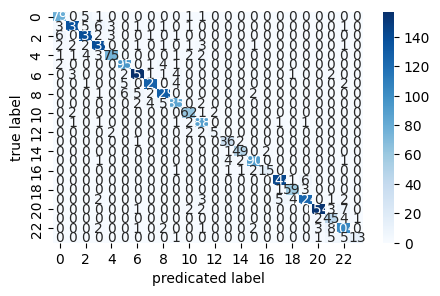

In [120]:
# 오차행렬표를 차트로 보여주는 작업_혼돈행렬
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

In [121]:
from sklearn.metrics import classification_report
print(classification_report(real_y, predict_y))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        87
           1       0.94      0.87      0.90       157
           2       0.89      0.91      0.90       152
           3       0.88      0.91      0.89       153
           4       0.90      0.84      0.87        89
           5       0.88      0.92      0.90       103
           6       0.93      0.92      0.92       171
           7       0.93      0.91      0.92       139
           8       0.90      0.89      0.90       145
           9       0.86      0.87      0.86        98
          10       0.85      0.93      0.89        67
          11       0.84      0.93      0.88        95
          12       0.71      0.45      0.56        11
          13       0.86      0.92      0.89        39
          14       0.91      0.94      0.92        52
          15       0.93      0.92      0.92        98
          16       0.88      0.75      0.81        20
          17       0.95    

## Applying to Test

In [124]:
from PIL import Image
import numpy as np
img=Image.open('c:/data/blackpants.jpg').resize((180,180)).convert('RGB')
img=np.array(img)

img=np.reshape(img, (1,180,180,3))
result=model.predict(img)
resultBun=np.argmax(result)
class_names[resultBun]

'brown_shoes'

In [125]:
model.save('c:/data/model/clothes/bestmodel/mymodel.h5')